In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# a) Target occupancy v.s.  KPP & gamma?

In [4]:
def findCriticalXPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2

def findCriticalKPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    CS0 = parm['CS0'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2/(CS0/0.6022)

In [5]:
GenParms = lambda nDenseKPP: GenParameters(
    numTargets=2, 
    KPN=np.array([30, 170, 1000]), 
    KPS=lambda KPN: 698.59327995, 
    NP0=[0.2], KPP=np.logspace(1,9,9+8*nDenseKPP), 
    gamma=[50],
)
parm_file = GenParms(10)
parm_num = GenParms(0)

In [6]:
occs = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    occs[iloc] = ana.ana_occupancy(parm, numClusterS=1)

equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

sOcc_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    sOcc_num_rev[iloc] = num.calc_occS_modelB(parm, equi_num_rev.iloc[iloc])

2025-05-01 12:29:15.072274
Number of cores used:  27/36
Finished parallel processing.


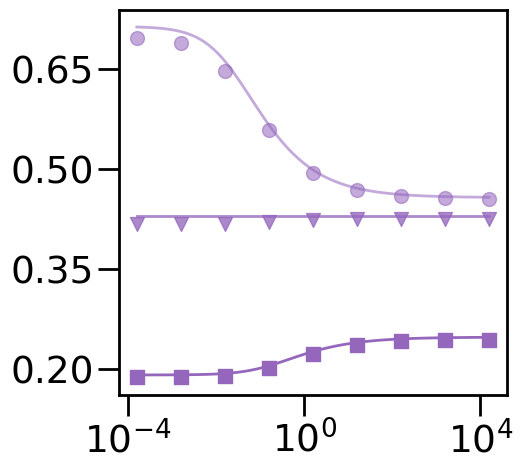

In [7]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[1.01,0.45], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{eq}^{PN}[N]_{tot}$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
gam_color = 'tab:purple'
alphas = [5/9, 7/9, 1]
# alphas = [1/9, 3/9, 5/9, 7/9, 1]
markers = ['o','v','s', 'X', 'p']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kpnList = np.unique(parm_file['KPN'])
CN0 = np.unique(parm_file['CN0'])
for i, kpn in enumerate(kpnList[::-1]):
    selected = ((parm_file['KPN']==kpn))
    selected_num = ((parm_num['KPN']==kpn))
    ax.plot(
        (parm_file['KPP']*parm_file['CP0'])[selected],
        (occs / (parm_file['CP0']/parm_file['CS0']))[selected], 
        color = gam_color, alpha=alphas[i], 
        lw=2, zorder=5,
    )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
        marker=markers[i],  zorder=4, s=100,
        color = gam_color, alpha=alphas[i], 
        label='$10^{%.1f}$'%(np.log10(CN0*kpn)),
    )
            
ax.semilogx()
plt.xticks([1e-4, 1e0, 1e4], ['$10^{-4}$', '$10^{0}$', '$10^{4}$'], **tickfont)
plt.yticks([0.2, 0.35, 0.5, 0.65],**tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

# b) residence time v.s. KPP & C0, dimer, model B

In [8]:
def criticalRate(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    kbPP = parm['kbPP'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    onRate = (kbPS*chiS + kbPN*chiN)
    return (onRate*gamma*chiN*2)/(1 + gamma*chiN)/chiS

In [9]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.2], area3Dto1D=[31],
    KPP=np.logspace(1,9,8+7*nDenseKPP), kbPP_fixed=kbP   
)

parm_num = pd.concat([GenParms(1e-2, 0), GenParms(1e-1, 0), GenParms(1e-0, 0)], axis=0)
parm_ana = pd.concat([GenParms(1e-2, 10), GenParms(1e-1, 10), GenParms(1e-0, 10)], axis=0)

In [10]:
# calculate the residence time considering PSN
def calc_tauB_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    kaStokaN = parms['kaPS']/parms['kaPN']
    CS0toCN0 = parms['CS0']/parms['CN0']
    tauN = 1/parms['kbPN']
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+kaStokaN*CS0toCN0)*tauN

resT_m_B_ana = calc_tauB_m(parm_ana)
resT_m_B_num = calc_tauB_m(parm_num)

resTs = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    parm = parm_ana.iloc[iloc]
    resTs[iloc] = ana.ana_resTime_balance(parm, numClusterS=1)

In [11]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

2025-05-01 12:29:15.644028
Number of cores used:  24/36
Finished parallel processing.


In [12]:
resT_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    resT_num_rev[iloc] = num.calc_resT_modelB(parm_num.iloc[iloc], equi_num_rev.iloc[iloc])

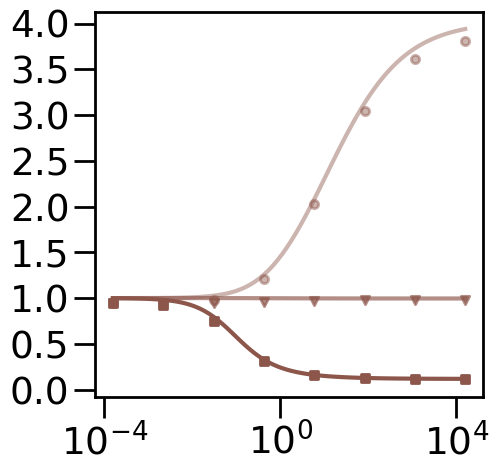

In [13]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.51], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [4/9, 6/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kbList = np.unique(parm_ana['kbPP'])
for i, kbP in enumerate(kbList):
    selected = parm_ana['kbPP']==kbP
    ax.plot(
        (parm_ana['KPP']*parm_ana['CP0'])[selected],
#         (resTs*parm_ana['kbPS'])[selected],
        (resTs/resT_m_B_ana)[selected],
        lw=3, color='tab:brown', alpha=alphas[i],
    )
    selected_num = parm_num['kbPP']==kbP
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
#         (resT_num_rev*parm_num['kbPS'])[selected_num],
        (resT_num_rev/resT_m_B_num)[selected_num],
        lw=2, zorder=5, marker=markers[i], 
        label='$10^{%.0f}$'%np.log10(kbP),
        color='tab:brown', alpha=alphas[i]
    )
ax.semilogx()
plt.xticks([1e-4,1e0,1e4],['$10^{-4}$', '$10^{0}$', '$10^{4}$'],**tickfont)
plt.yticks(**tickfont)
plt.show()

# c) protein bound ratio (irr, rev, m)

In [14]:
GenParms = lambda KPNList, KPP: GenParameters(
    numTargets=2, KPN=KPNList, KPS=lambda KPN: 1e4, 
    NP0=[0.2], KPP=[KPP], area3Dto1D=[10, 1000],
)
KPP_rev = 1e6

In [15]:
parm_ana = GenParms(np.logspace(1, 3, 5+2*40)*2.0, KPP_rev)

parm_num_irr = GenParms(np.logspace(1, 3, 5+2*0)*2.0, np.inf)
parm_num_rev = GenParms(np.logspace(1, 3, 5+2*0)*2.0, KPP_rev)
parm_num_m = GenParms(np.logspace(1, 3, 5+2*0)*2.0, 0)

In [16]:
def pBound_irr(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    return proBound / (1 + proBound)

def pBound_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = chiN + chiS*(1+gam*chiN)
    return proBound / (1 + proBound)

pBound_irr = pBound_irr(parm_ana)
pBound_m = pBound_m(parm_ana)
pBound_rev = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    pBound_rev[iloc] = ana.ana_bound_ratio(parm_ana.iloc[iloc], numClusterS=1)

In [17]:
equi_irr = numericSolver(parm_df=parm_num_irr, labels=labelsSingleS, model=rxnSingleS)
equi_m = numericSolver(parm_df=parm_num_m, labels=labelsSingleS, model=rxnSingleS)
equi_rev = numericSolver(parm_df=parm_num_rev, labels=labelsSingleS, model=rxnSingleS)

pBound_num_m = np.zeros(parm_num_m.shape[0])
pBound_num_irr = np.zeros(parm_num_m.shape[0])
pBound_num_rev = np.zeros(parm_num_m.shape[0])
for iloc in range(parm_num_m.shape[0]):
    pBound_num_m[iloc] = num.calc_BoundRatio_modelB(parm_num_m.iloc[iloc], equi_m.iloc[iloc])
    pBound_num_irr[iloc] = num.calc_BoundRatio_modelB(parm_num_irr.iloc[iloc], equi_irr.iloc[iloc])
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelB(parm_num_rev.iloc[iloc], equi_rev.iloc[iloc])

2025-05-01 12:29:16.738730
Number of cores used:  10/36
Finished parallel processing.
2025-05-01 12:29:17.053865
Number of cores used:  10/36
Finished parallel processing.
2025-05-01 12:29:17.348097
Number of cores used:  10/36
Finished parallel processing.


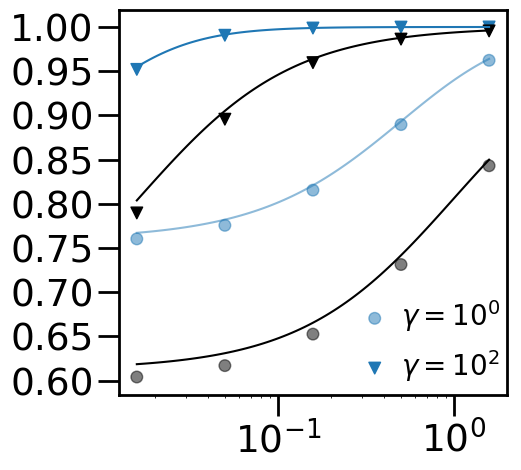

In [18]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.62,0.00], lgdFontSize=20, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=20,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_gamma = 'tab:blue'
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
for j, gam in enumerate(gamList):
    selected = ((parm_ana['gamma']==gam))
    # analytics
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_irr[selected], ls='-',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_m[selected],
        color='black',
    )
    # numerics
    selected_num = ((parm_num_irr['gamma']==gam))
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_irr[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected_num],
        pBound_num_m[selected_num],  s=70,
        marker=markers[j], alpha=alphas[j],
        ls='', color='black',
    )
    
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
# plt.grid(axis='x')
plt.savefig('pBound_vs_chiN_gamma.png', transparent=True)
# plt.show()